<table width='100%'>
<tr>
<td style='background-color:white'>
    <p align="left">
    Part I<br>
        <b>Lab Machine Learning for Data Science</b><br>
    Summer Semester 2024
    </p>
</td>
<td style='background-color:white'>
    Evita Vardhani - 5587165<br>
    Hyeonhui Lee - 5585677<br>
    Jing Chen - 5582644<br>
</td>
</tr>
</table>

<br>
<center>
    <h1>Getting Insights into an Unsupervised Dataset</h1>
</center>
<br>

In [ ]:
!pip3 install -U ucimlrepo
!pip3 install dash
!pip3 install dash_bootstrap_components

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.5/222.5 kB 2.0 MB/s eta 0:00:00


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
import scipy
warnings.filterwarnings('ignore')
from sklearn.manifold import TSNE


from ucimlrepo import fetch_ucirepo

# 1. Loading the data, Preprocessing, Initial Data Analysis

## 1.1. Loading the data

In [ ]:
# fetch dataset
wholesale_customers = fetch_ucirepo(id=292)

# data (as pandas dataframes)
X = wholesale_customers.data.features
y = wholesale_customers.data.targets

# metadata
print(wholesale_customers.metadata)

{'uci_id': 292, 'name': 'Wholesale customers', 'repository_url': 'https://archive.ics.uci.edu/dataset/292/wholesale+customers', 'data_url': 'https://archive.ics.uci.edu/static/public/292/data.csv', 'abstract': 'The data set refers to clients of a wholesale distributor. It includes the annual spending in monetary units (m.u.) on diverse product categories', 'area': 'Business', 'tasks': ['Classification', 'Clustering'], 'characteristics': ['Multivariate'], 'num_instances': 440, 'num_features': 7, 'feature_types': ['Integer'], 'demographics': [], 'target_col': ['Region'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2013, 'last_updated': 'Mon Feb 05 2024', 'dataset_doi': '10.24432/C5030X', 'creators': ['Margarida Cardoso'], 'intro_paper': None, 'additional_info': {'summary': None, 'purpose': None, 'funded_by': None, 'instances_represent': None, 'recommended_data_splits': None, 'sensitive_data': None, 'preprocessing_description':

In [ ]:
data = pd.concat([X, y], axis=1)

## 1.2. Preprocessing

In [ ]:
# Counting the number of missing values per column
print(data.isna().sum())

Channel             0
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
Region              0
dtype: int64


In [ ]:
# Drop the metadata
X = data.drop("Channel", axis=1)
X = X.drop("Region", axis=1)

In [ ]:
X.head(5)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,12669,9656,7561,214,2674,1338
1,7057,9810,9568,1762,3293,1776
2,6353,8808,7684,2405,3516,7844
3,13265,1196,4221,6404,507,1788
4,22615,5410,7198,3915,1777,5185


In [ ]:
# Convert it into numpy array
X_arr = np.array(X)

## 1.3. Initial Data Analysis

### 1.3.1. Histogram and scatterplots

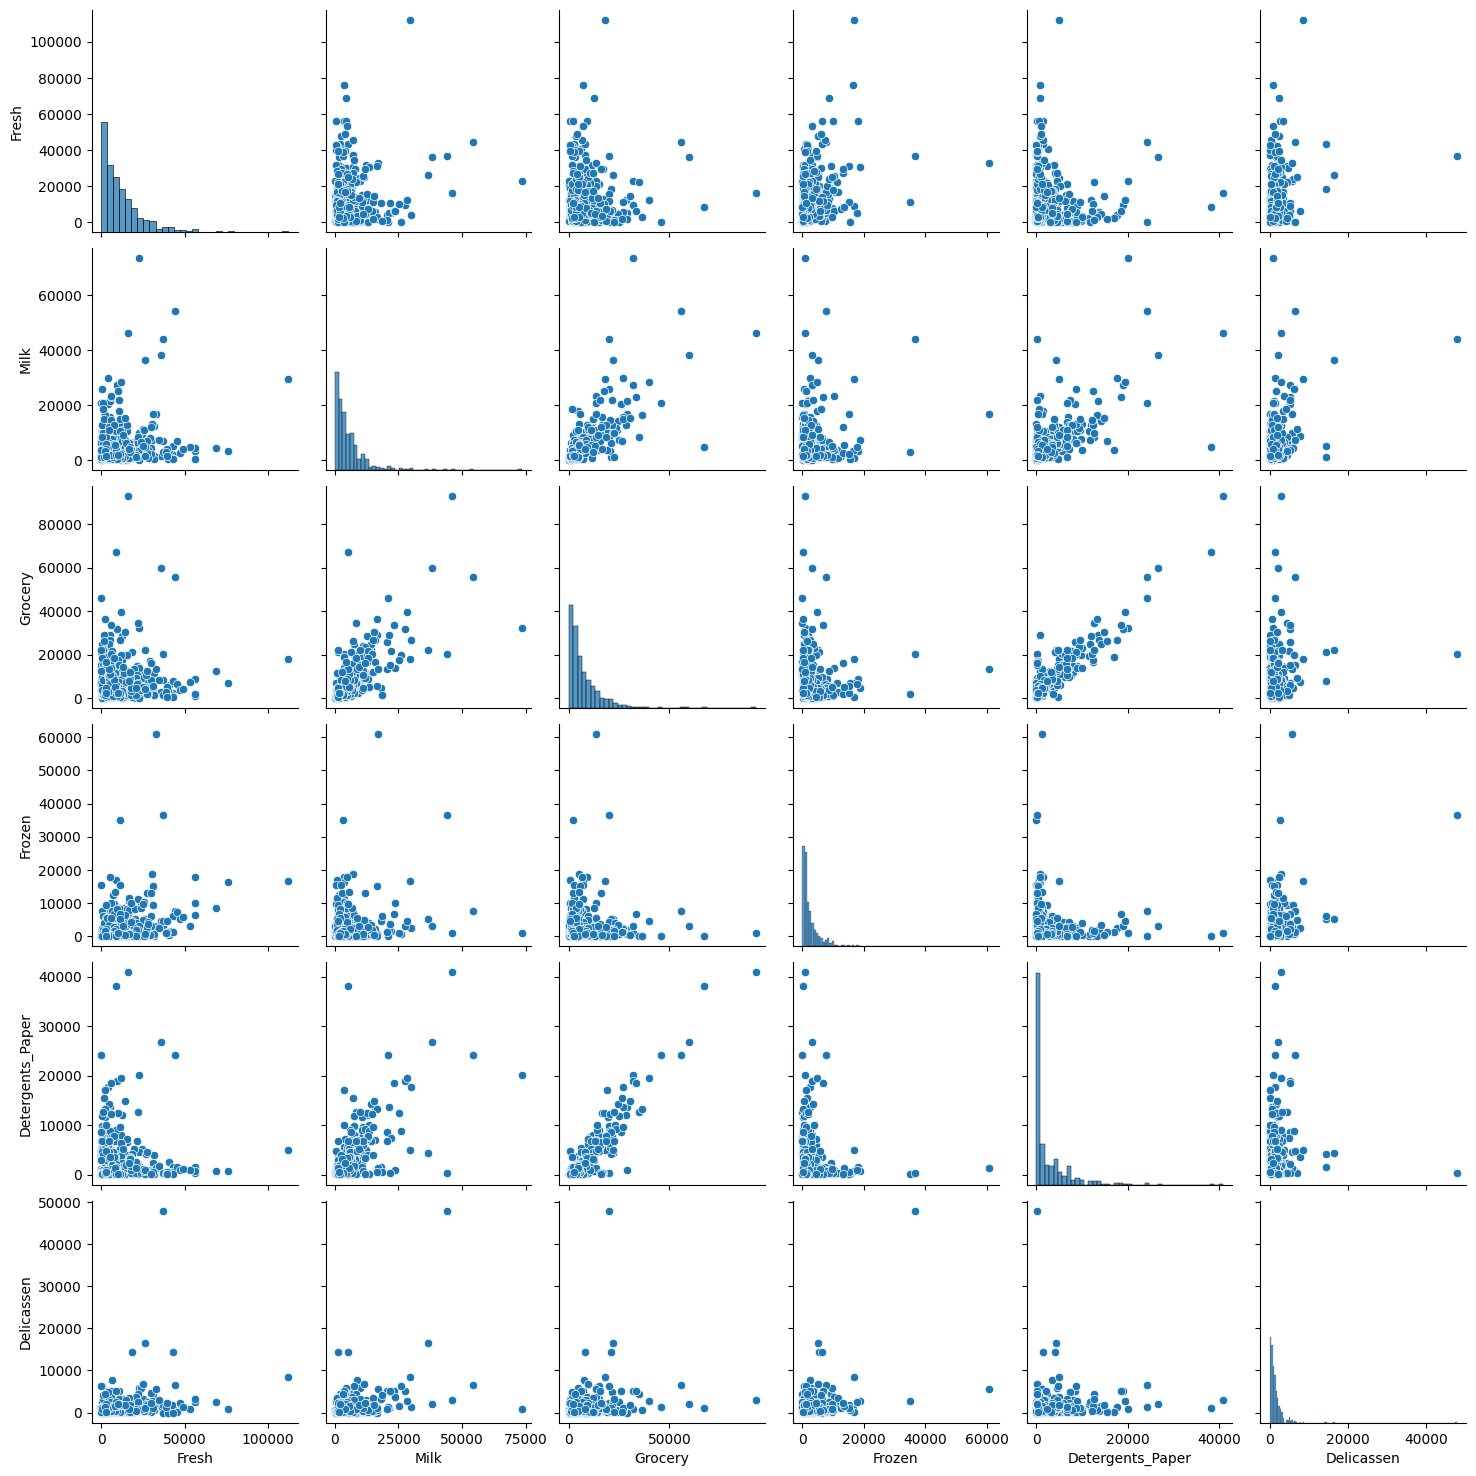

In [ ]:
sns.pairplot(data=X)

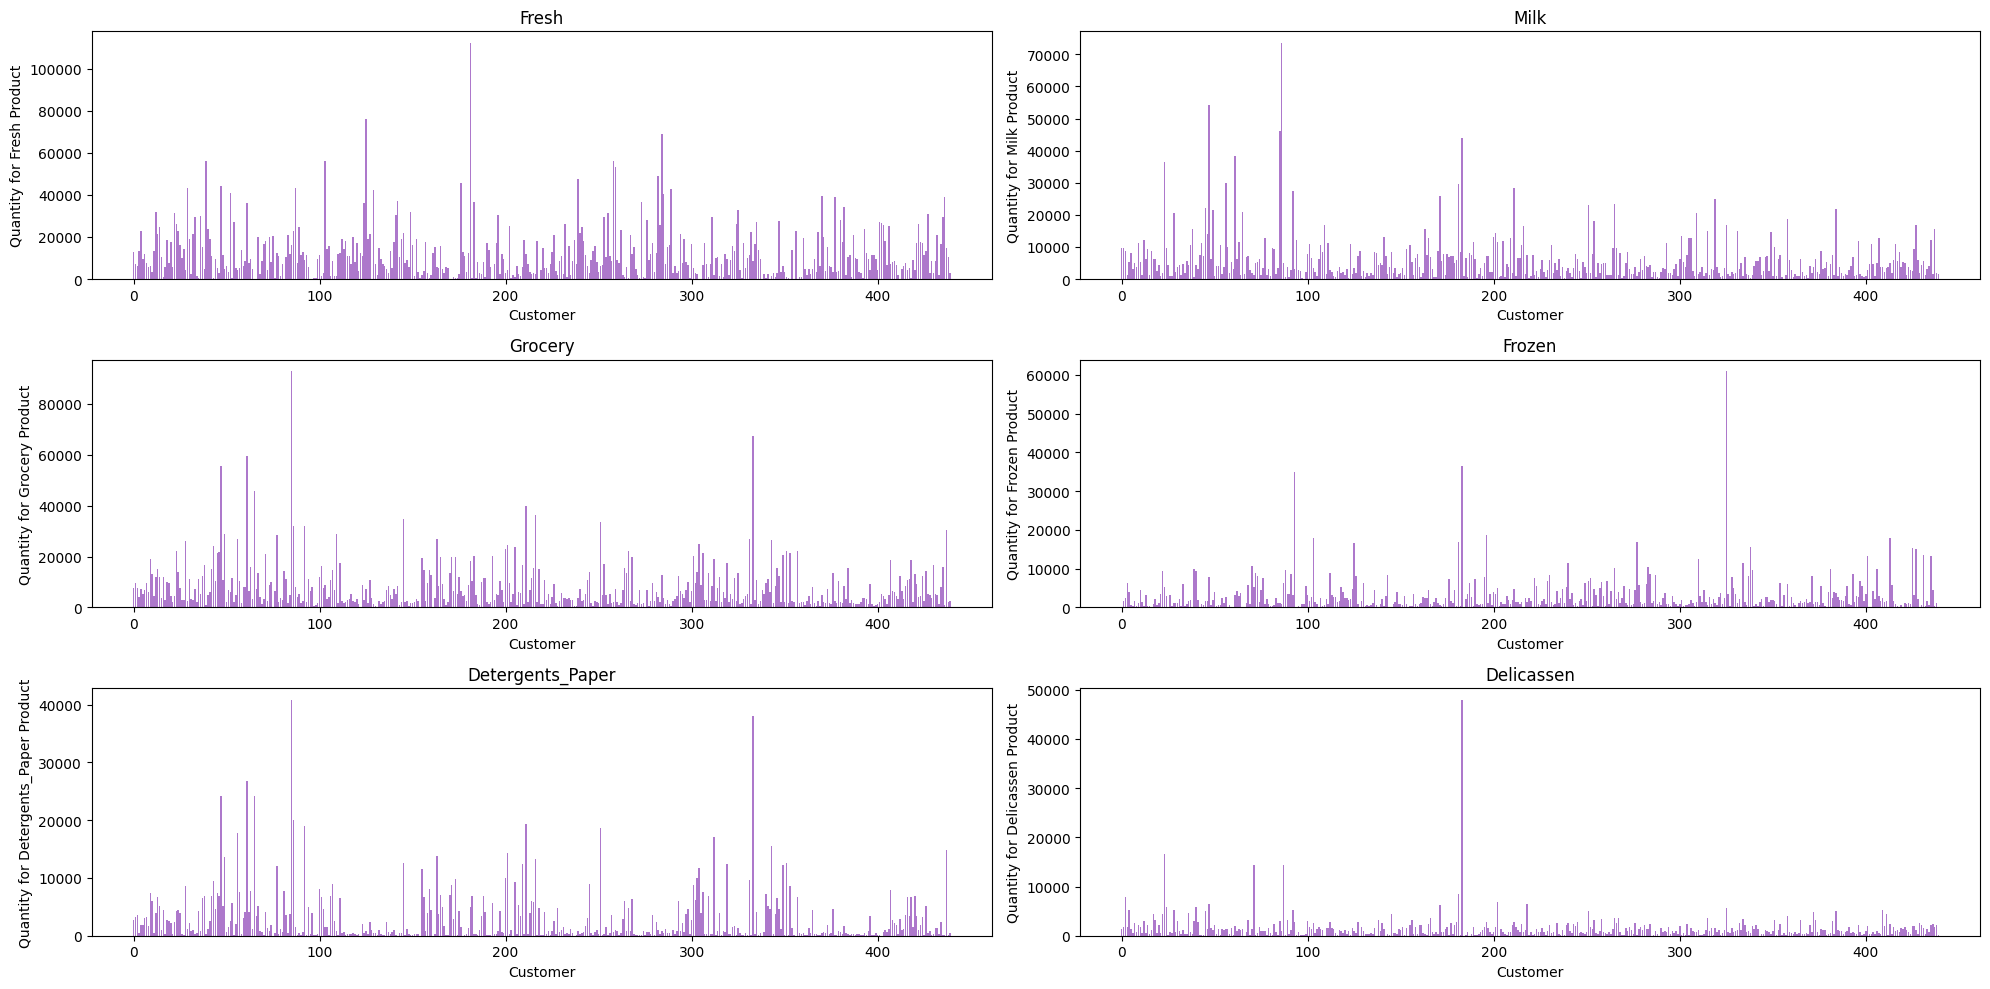

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(20,10))
start_index=0
for idx, column_name in enumerate(X):
    if idx >= start_index:

        row = (idx-start_index) // 2
        col = (idx-start_index) % 2

        ax[row,col].bar(X[column_name].index, X[column_name], color='#AD78CB')
        ax[row,col].set_xlabel('Customer')
        ax[row,col].set_ylabel('Quantity for {} Product'.format(column_name))
        ax[row,col].set_title(column_name)

plt.tight_layout()
plt.show()

### 1.3.2. Non-linear transformation

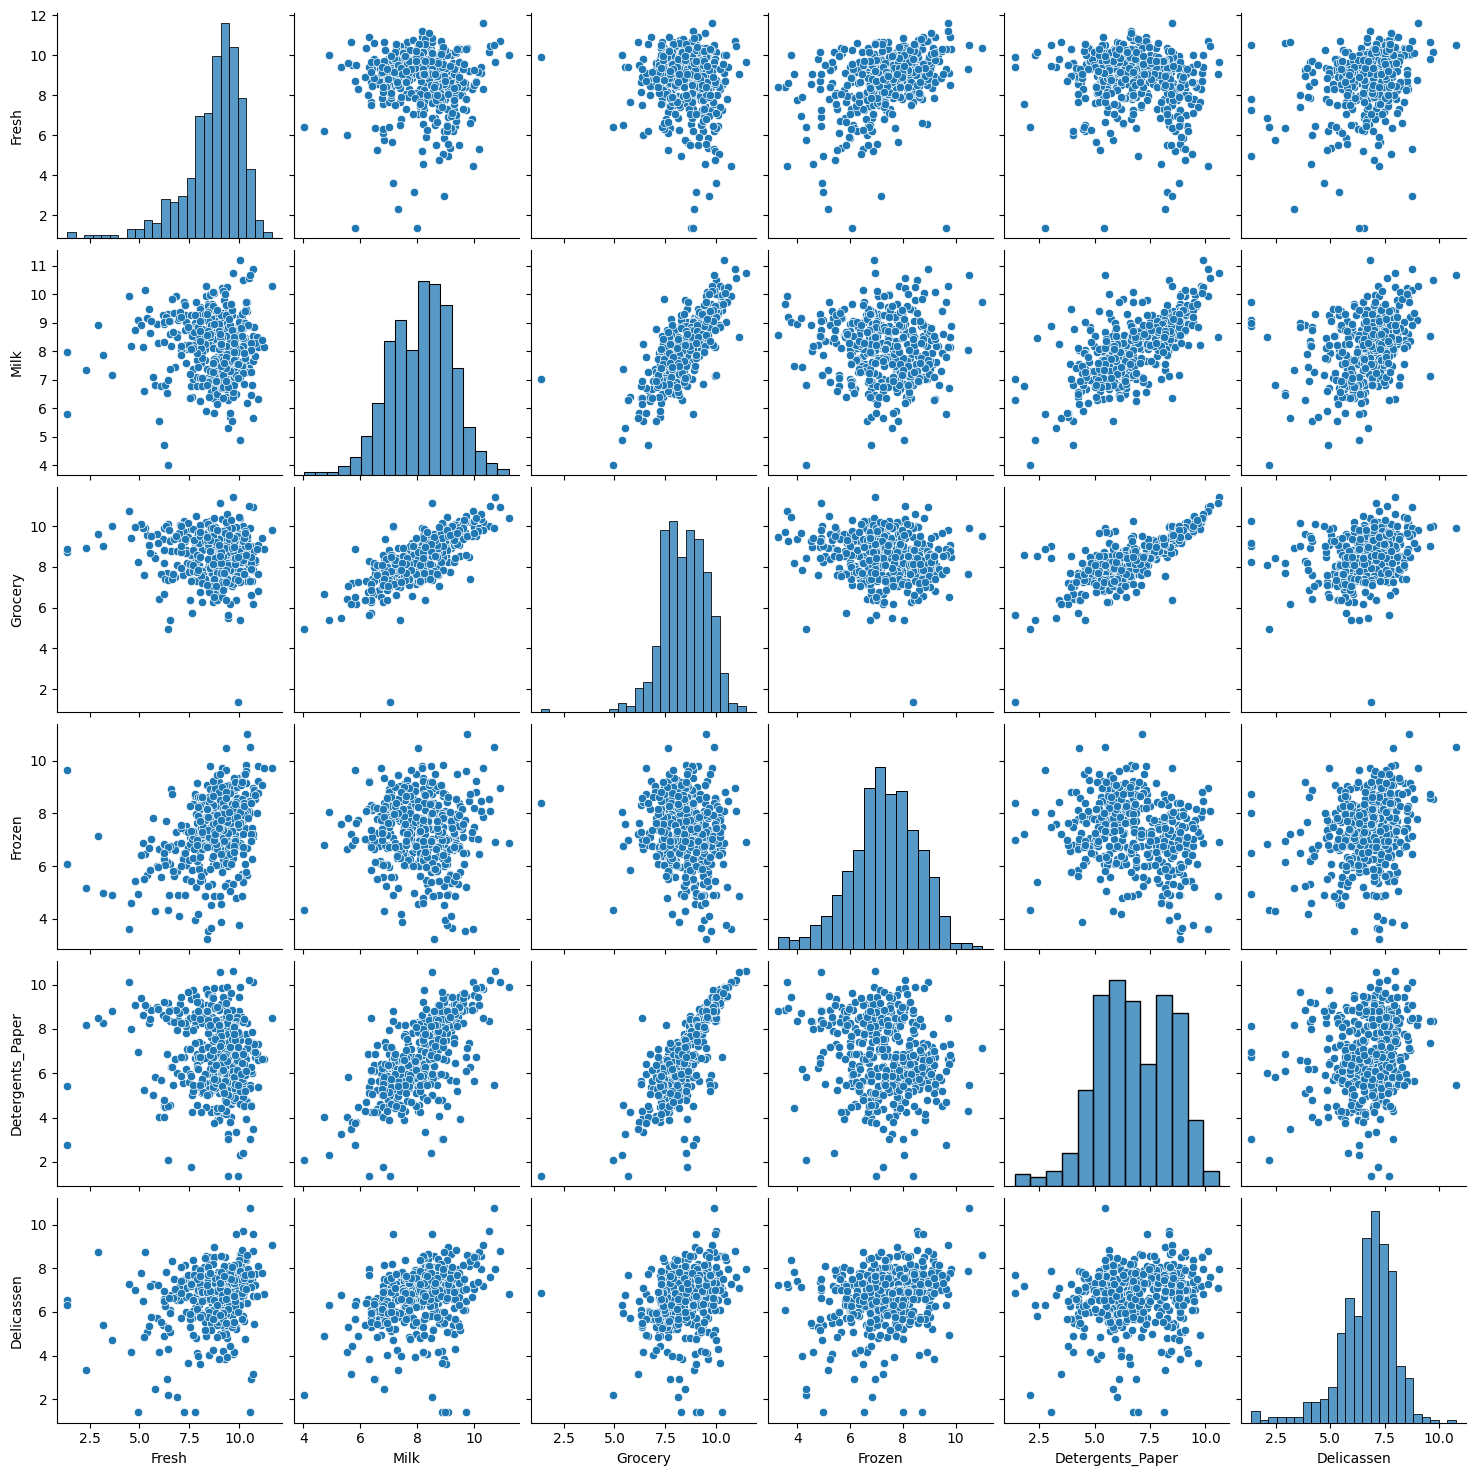

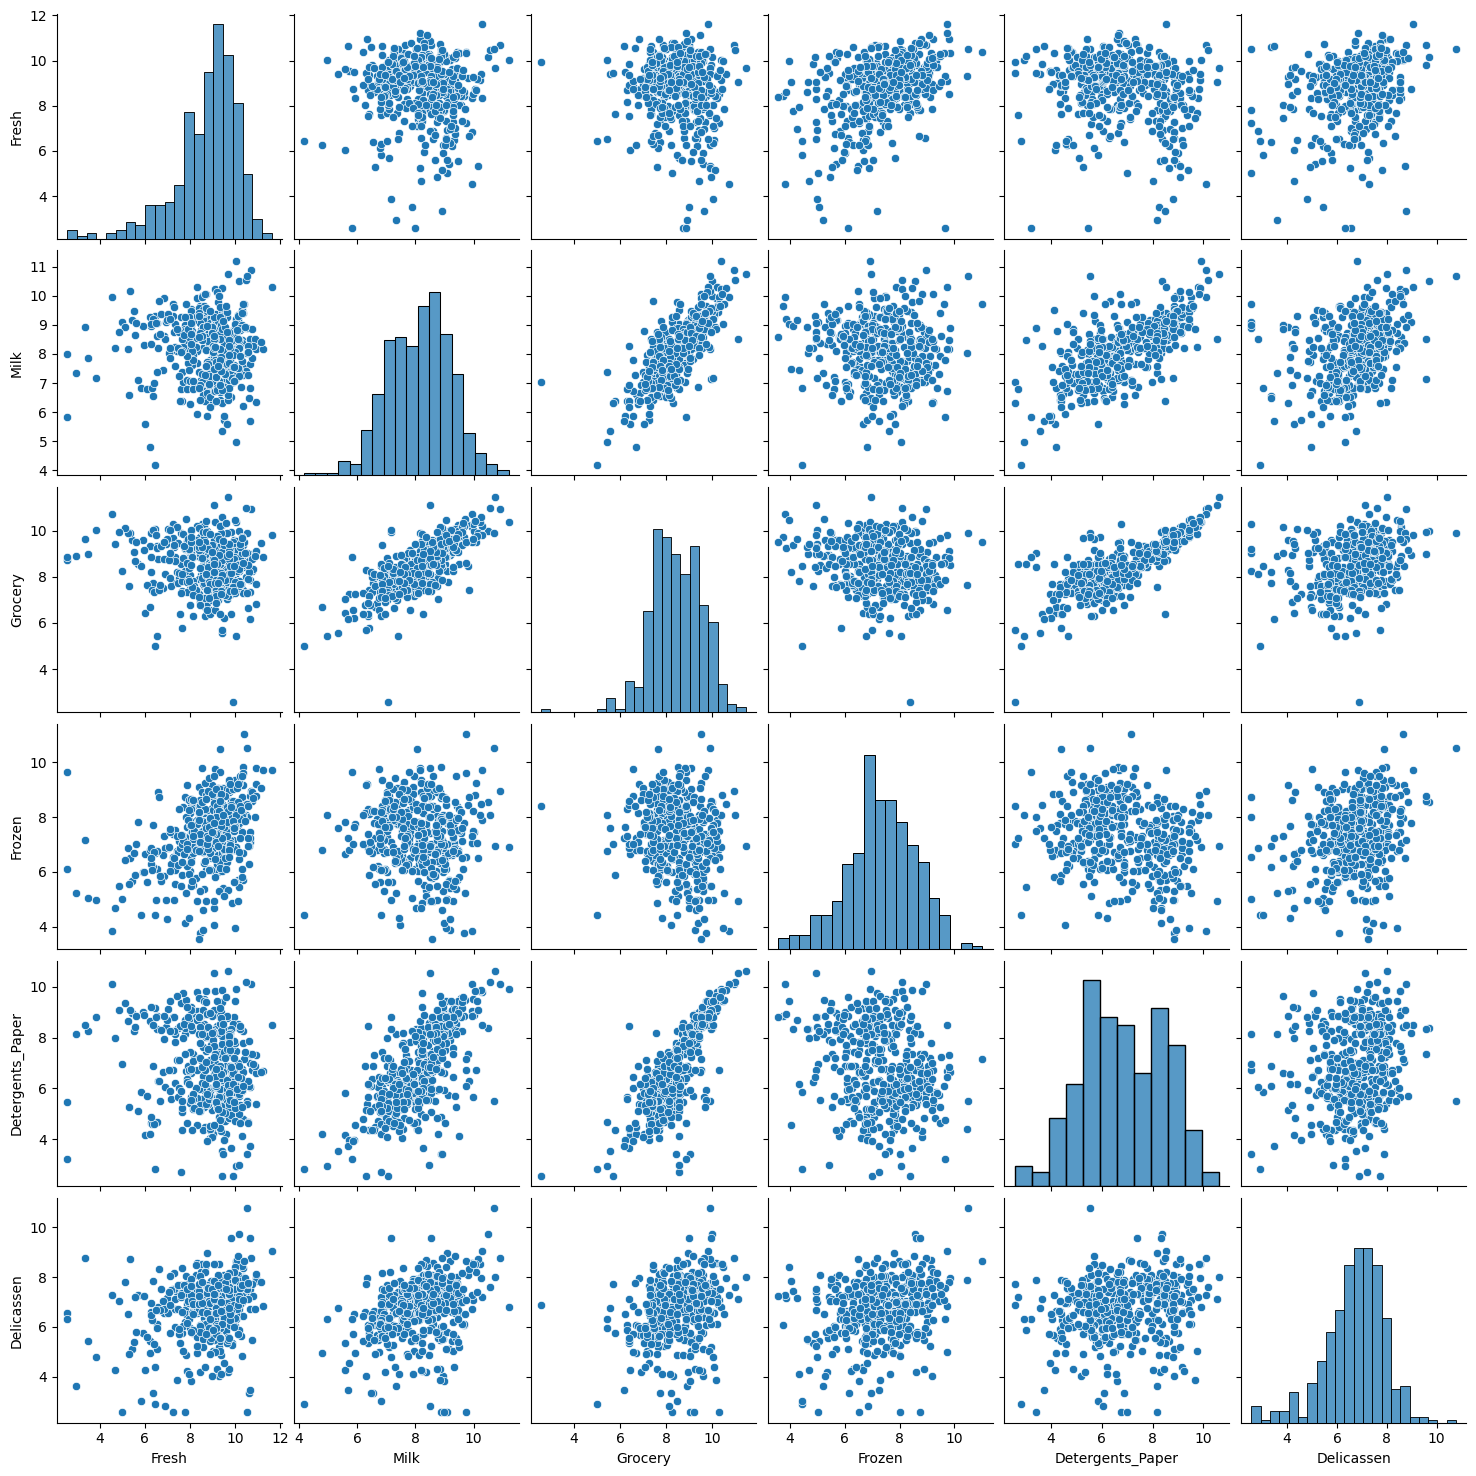

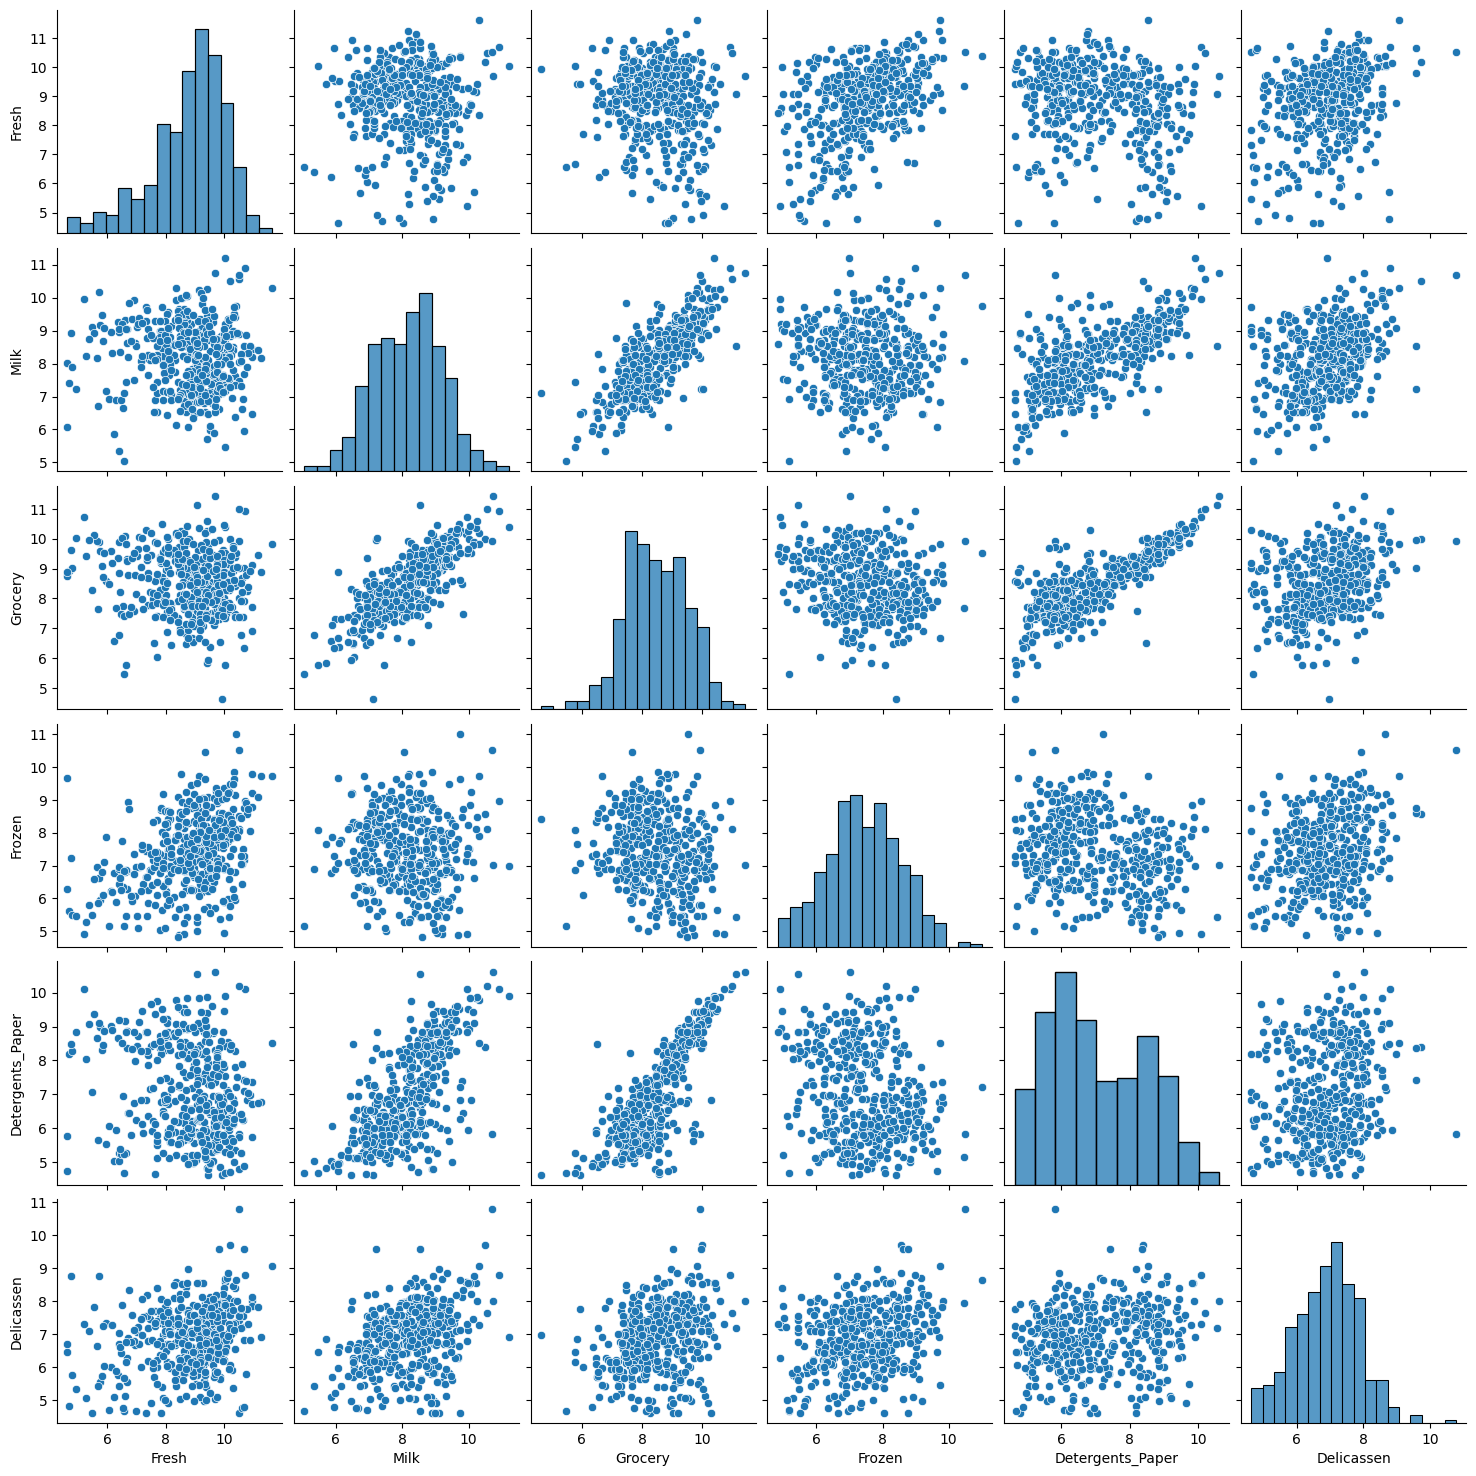

In [ ]:
sns.pairplot(data=np.log(X + 1))
sns.pairplot(data=np.log(X + 10))
sns.pairplot(data=np.log(X + 100))

In [ ]:
X_arr = np.log(X_arr + 10)

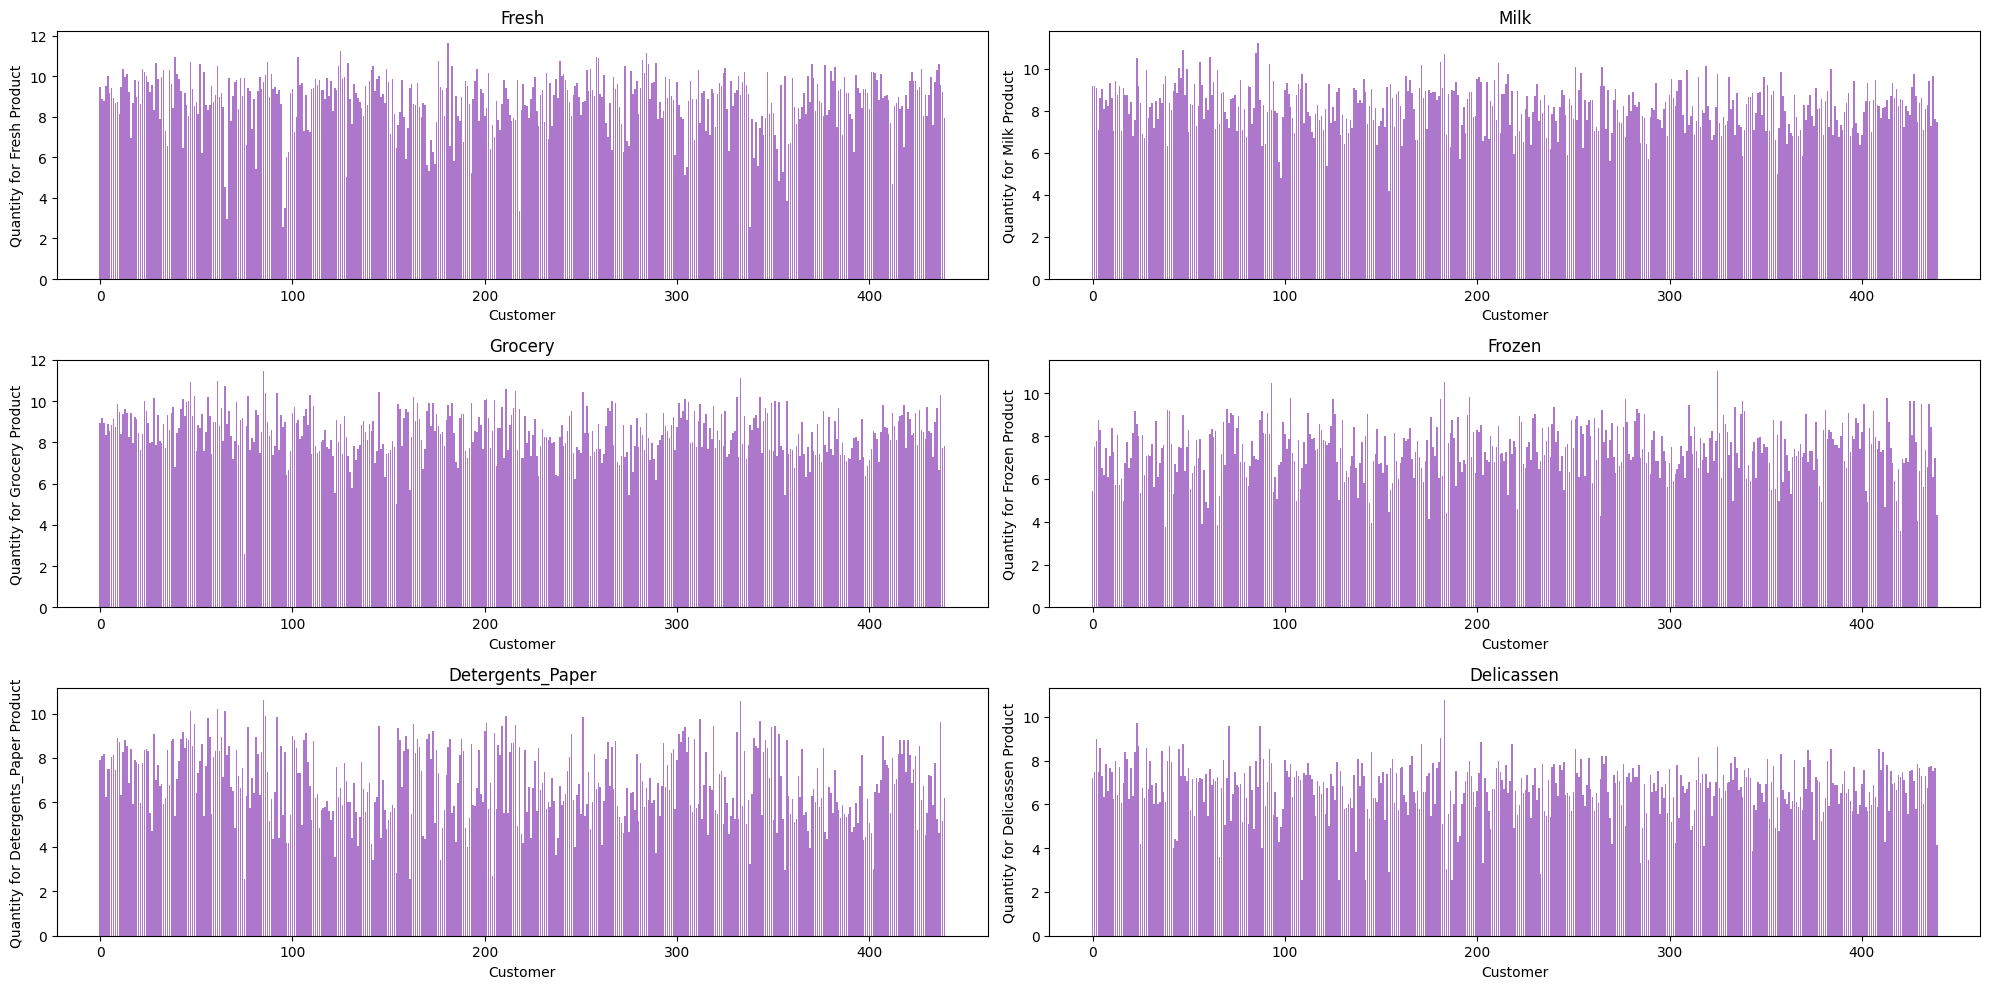

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(20, 10))

for idx in range(X_arr.shape[1]):
    row = idx // 2
    col = idx % 2

    column_data = X_arr[:, idx]

    ax[row, col].bar(np.arange(len(column_data)), column_data, color='#AD78CB')
    ax[row, col].set_xlabel('Customer')
    ax[row, col].set_ylabel('Quantity for {} Product'.format(X.columns[idx]))
    ax[row, col].set_title('{}'.format(X.columns[idx]))

plt.tight_layout()
plt.show()

# 2. Detecting Anomalies

## 2.1. Hard minimum

In [ ]:
# the nearest neighbor
def outlier_score_hardmin(arr):

    scores = []
    N = arr.shape[0]
    for j in range(N):
        y = np.inf
        for k in range(N):
            if k != j:
                z = np.linalg.norm(arr[j] - arr[k]) ** 2
                if z < y:
                    y = z
        scores.append(y)
    return scores

In [ ]:
# top 10
dic = {"score": [], "Fresh": [], "Milk": [], "Grocery": [], "Frozen": [], "Detergents_Paper": [], "Delicassen": []}
outlier_scores = outlier_score_hardmin(X_arr)
indices = []
for idx in np.argsort(outlier_scores)[-10:][::-1]:
    indices.append(idx)
    dic["score"].append(outlier_scores[idx])
    dic["Fresh"].append(X_arr[idx][0])
    dic["Milk"].append(X_arr[idx][1])
    dic["Grocery"].append(X_arr[idx][2])
    dic["Frozen"].append(X_arr[idx][3])
    dic["Detergents_Paper"].append(X_arr[idx][4])
    dic["Delicassen"].append(X_arr[idx][5])
df = pd.DataFrame(dic, index=indices)

In [ ]:
df

,score,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
338,19.200908,2.564949,5.837730,8.858084,9.655731,3.218876,6.327937
75,13.094220,9.923682,7.044905,2.564949,8.393216,2.564949,6.892642
154,12.870776,6.448889,4.174387,4.990433,4.442651,2.833213,2.890372
95,11.329252,2.564949,7.982758,8.742255,6.109248,5.451038,6.577861
183,8.636633,10.514801,10.691035,9.912447,10.506272,5.517453,10.777977
142,8.582687,10.519916,8.876545,9.019543,8.008033,3.401197,2.564949
187,6.556690,7.803027,8.988696,9.193092,8.744966,8.151622,2.564949
128,6.389484,5.010635,9.088963,8.251403,5.023881,6.977281,2.564949
228,6.165231,7.538495,6.375025,6.366470,6.866933,8.470521,5.361292
65,5.947661,4.553877,9.950800,10.732869,3.828641,10.095801,7.267525


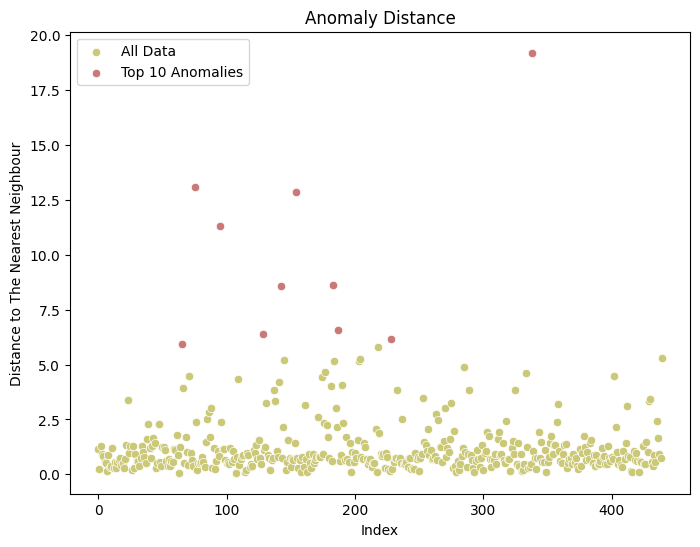

In [ ]:
#Visualize the top 10 anomaly distance
plt.figure(figsize=(8, 6))
sns.scatterplot(x=range(len(outlier_scores)), y=outlier_scores, color='#CBC878', label='All Data')
sns.scatterplot(x=df.index, y=df.score, color='#CB7878', label='Top 10 Anomalies')
plt.xlabel('Index')
plt.ylabel('Distance to The Nearest Neighbour')
plt.title('Anomaly Distance')
plt.legend()
plt.show()

In [ ]:
dic_all = {"score": [], "Fresh": [], "Milk": [], "Grocery": [], "Frozen": [], "Detergents_Paper": [], "Delicassen": []}
indices = []
for idx in range(len(outlier_scores)):
    indices.append(idx)
    dic_all["score"].append(outlier_scores[idx])
    dic_all["Fresh"].append(X_arr[idx][0])
    dic_all["Milk"].append(X_arr[idx][1])
    dic_all["Grocery"].append(X_arr[idx][2])
    dic_all["Frozen"].append(X_arr[idx][3])
    dic_all["Detergents_Paper"].append(X_arr[idx][4])
    dic_all["Delicassen"].append(X_arr[idx][5])
df_all = pd.DataFrame(dic_all, index=indices)

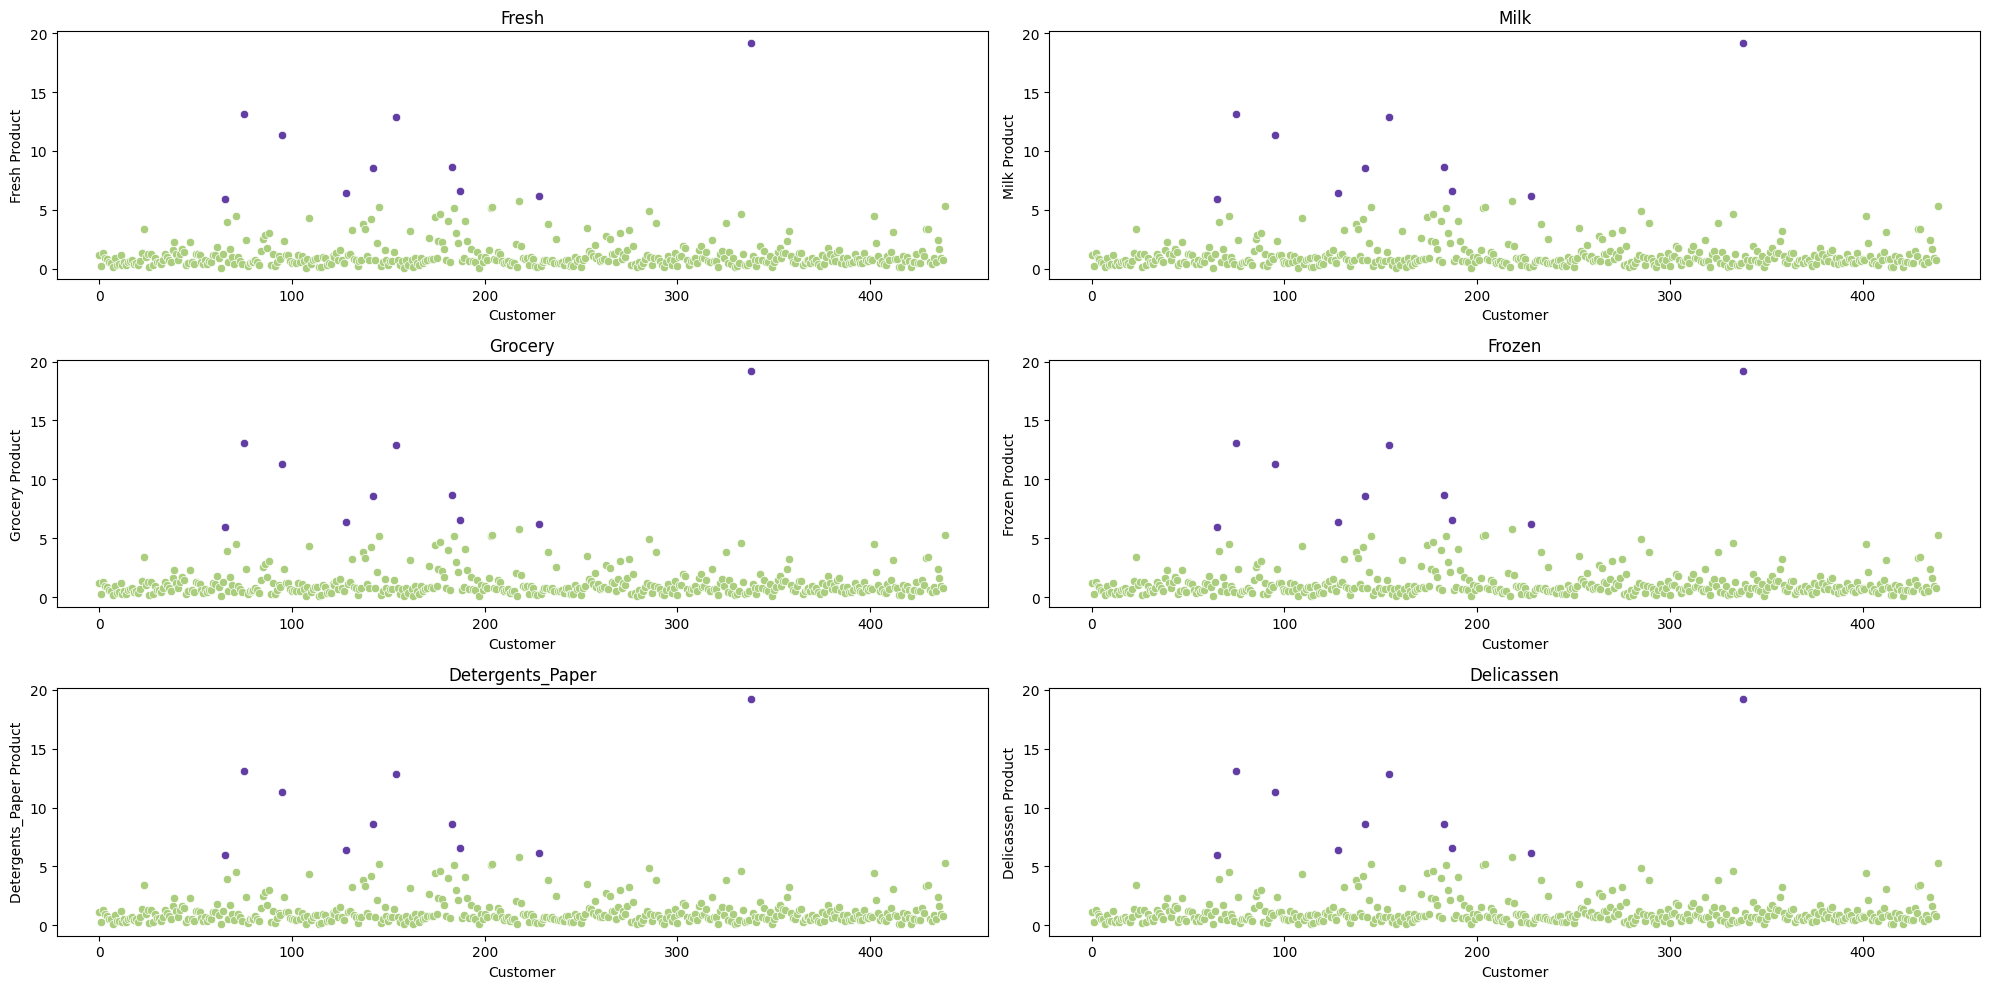

In [ ]:
#visualize the top 10 anomaly data for each product
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(20, 10))
start_index = 0
for idx, column_name in enumerate(df_all.columns[1:]):
    if idx >= start_index:

        row = (idx - start_index) // 2
        col = (idx - start_index) % 2
        sns.scatterplot(data=df_all, x=df_all.index, y=df_all.score, ax=ax[row, col], color='#AACE7E')
        sns.scatterplot(data=df, x=df.index, y=df.score, ax=ax[row, col], color='#613DA4')
        ax[row, col].set_xlabel('Customer')
        ax[row, col].set_ylabel('{} Product'.format(column_name))
        ax[row, col].set_title(column_name)

plt.tight_layout()
plt.show()

## 2.2. Soft minimum for reproducibility

In [ ]:
def outlier_score_softmin(arr, gamma):

    scores = []
    N = arr.shape[0] # 440
    for j in range(N):
        sum = 0
        for k in range(N):
            if k != j:
                z = np.linalg.norm(arr[j] - arr[k]) ** 2
                sum += np.exp(-1 * gamma * z)
        y = -1 * (1 / gamma) * np.log((1 / (N - 1)) * sum)
        ###
        if y == np.inf :
            print(np.log((1 / (N - 1)) * sum))
            print(f'something is wrong here {j}, {k}, {z}, {sum:.3f}')
        ###
        scores.append(y)
    return scores

In [ ]:
# top 10 if gamma = 1
dic = {"score": [], "Fresh": [], "Milk": [], "Grocery": [], "Frozen": [], "Detergents_Paper": [], "Delicassen": []}
outlier_scores = outlier_score_softmin(X_arr, 1)
indices = []
for idx in np.argsort(outlier_scores)[-10:][::-1]:
    indices.append(idx)
    dic["score"].append(outlier_scores[idx])
    dic["Fresh"].append(X_arr[idx][0])
    dic["Milk"].append(X_arr[idx][1])
    dic["Grocery"].append(X_arr[idx][2])
    dic["Frozen"].append(X_arr[idx][3])
    dic["Detergents_Paper"].append(X_arr[idx][4])
    dic["Delicassen"].append(X_arr[idx][5])
df = pd.DataFrame(dic, index=indices)

In [ ]:
df

,score,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
338,25.238464,2.564949,5.837730,8.858084,9.655731,3.218876,6.327937
154,18.837628,6.448889,4.174387,4.990433,4.442651,2.833213,2.890372
75,18.216776,9.923682,7.044905,2.564949,8.393216,2.564949,6.892642
95,17.222321,2.564949,7.982758,8.742255,6.109248,5.451038,6.577861
142,14.650633,10.519916,8.876545,9.019543,8.008033,3.401197,2.564949
183,14.470217,10.514801,10.691035,9.912447,10.506272,5.517453,10.777977
128,12.070920,5.010635,9.088963,8.251403,5.023881,6.977281,2.564949
187,11.991264,7.803027,8.988696,9.193092,8.744966,8.151622,2.564949
65,11.914168,4.553877,9.950800,10.732869,3.828641,10.095801,7.267525
218,11.393690,3.332205,8.924523,9.630037,7.166266,8.477828,8.761237


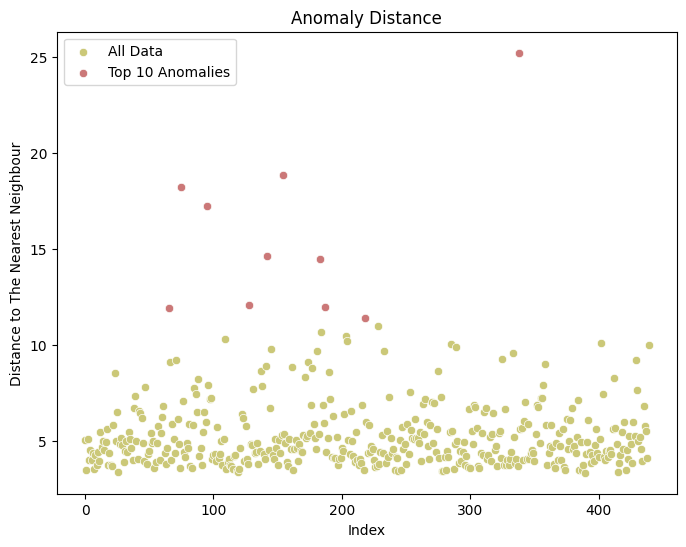

In [ ]:
#Visualize the top 10 anomaly distance
plt.figure(figsize=(8, 6))
sns.scatterplot(x=range(len(outlier_scores)), y=outlier_scores, color='#CBC878', label='All Data')
sns.scatterplot(x=df.index, y=df.score, color='#CB7878', label='Top 10 Anomalies')
plt.xlabel('Index')
plt.ylabel('Distance to The Nearest Neighbour')
plt.title('Anomaly Distance')
plt.legend()
plt.show()

In [ ]:
dic_all = {"score": [], "Fresh": [], "Milk": [], "Grocery": [], "Frozen": [], "Detergents_Paper": [], "Delicassen": []}
indices = []
for idx in range(len(outlier_scores)):
    indices.append(idx)
    dic_all["score"].append(outlier_scores[idx])
    dic_all["Fresh"].append(X_arr[idx][0])
    dic_all["Milk"].append(X_arr[idx][1])
    dic_all["Grocery"].append(X_arr[idx][2])
    dic_all["Frozen"].append(X_arr[idx][3])
    dic_all["Detergents_Paper"].append(X_arr[idx][4])
    dic_all["Delicassen"].append(X_arr[idx][5])
df_all = pd.DataFrame(dic_all, index=indices)

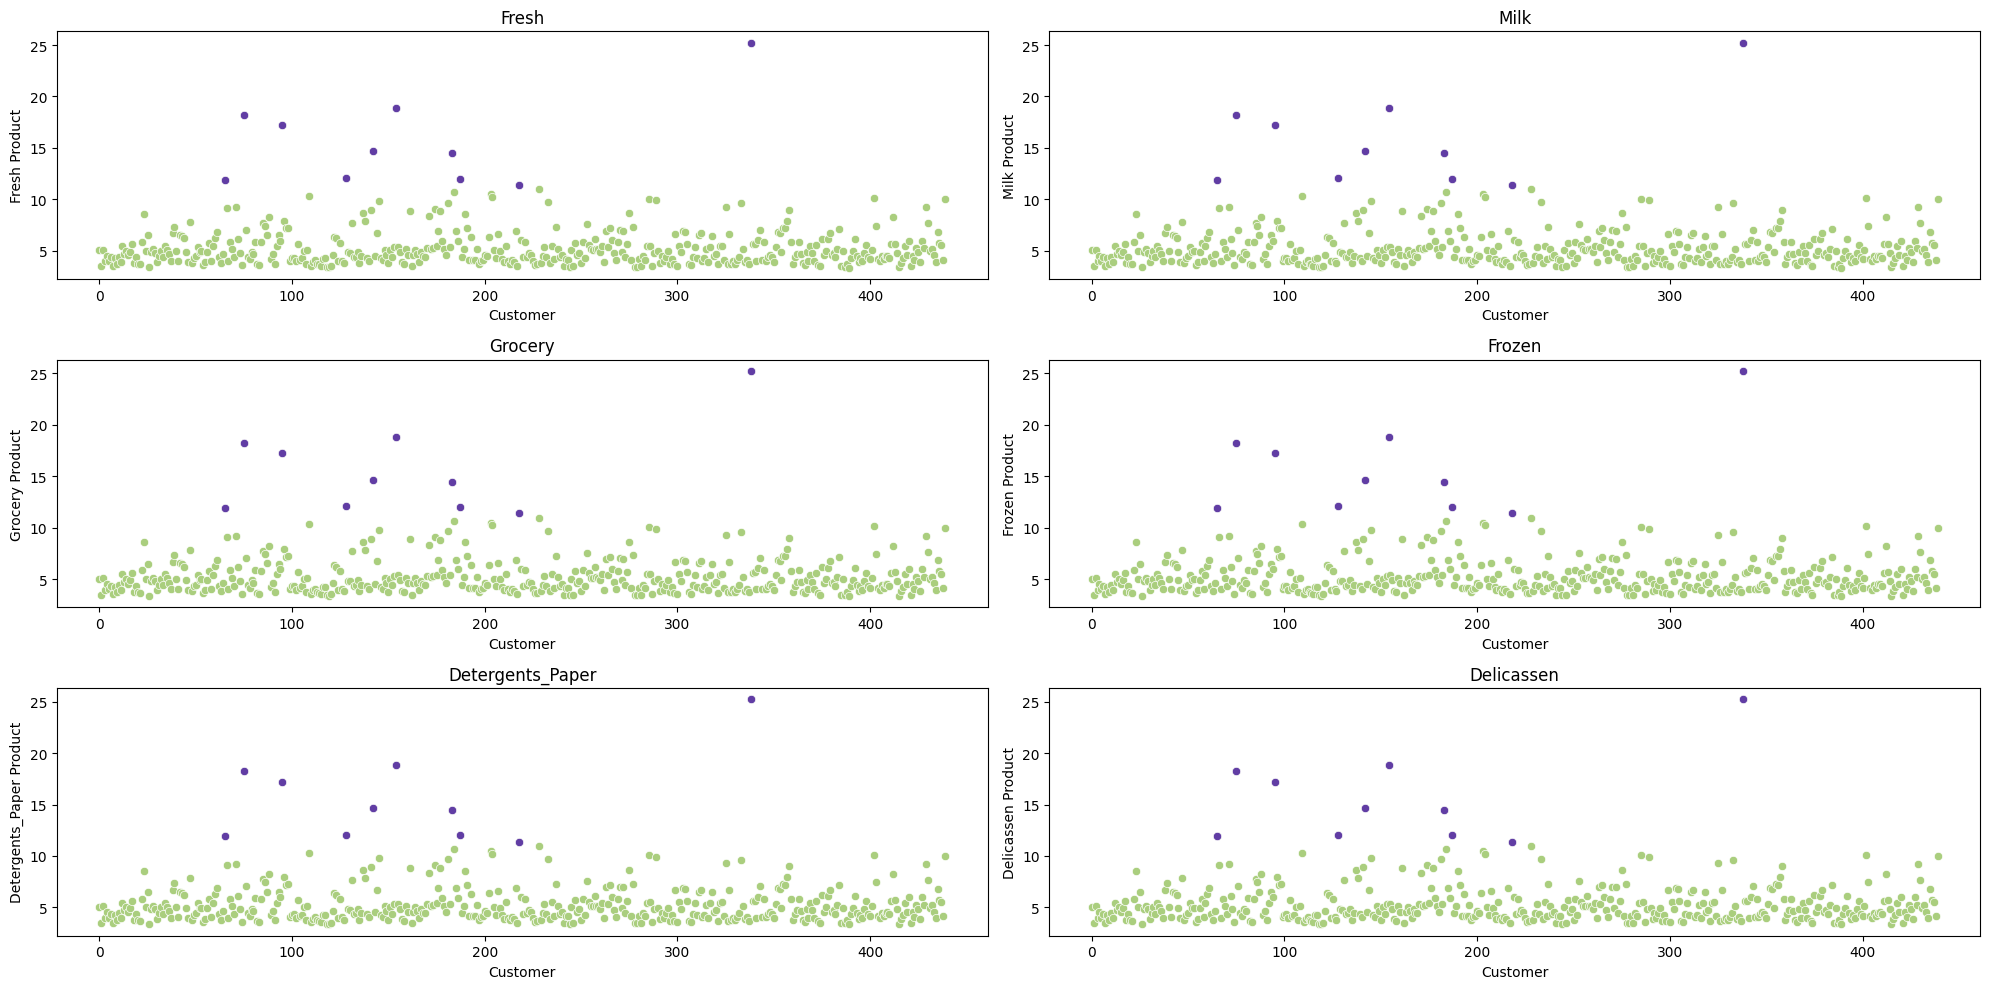

In [ ]:
#visualize the top 10 anomaly data for each product
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(20, 10))
start_index = 0
for idx, column_name in enumerate(df_all.columns[1:]):
    if idx >= start_index:

        row = (idx - start_index) // 2
        col = (idx - start_index) % 2
        sns.scatterplot(data=df_all, x=df_all.index, y=df_all.score, ax=ax[row, col], color='#AACE7E')
        sns.scatterplot(data=df, x=df.index, y=df.score, ax=ax[row, col], color='#613DA4')
        ax[row, col].set_xlabel('Customer')
        ax[row, col].set_ylabel('{} Product'.format(column_name))
        ax[row, col].set_title(column_name)

plt.tight_layout()
plt.show()

## 2.3. Bootstrapping
sample size : 300 \
the number of sampling: 1000 \
(with repetition)

In [ ]:
def bootstrap(num_sampling, size_sample, num_original, gamma):
    sampling_results = np.zeros((num_sampling, num_original))
    for n in range(num_sampling):
        # the size of a sample: 300
        indices = np.random.randint(low=0, high=num_original, size=size_sample)
        sample = X_arr[indices]
        outlier_scores = outlier_score_softmin(sample, gamma=gamma)
        for idx, value in enumerate(indices):
            sampling_results[n, value] = outlier_scores[idx]
    return sampling_results

In [ ]:
N = X_arr.shape[0] # 440

In [ ]:
# gamma == 0.001
sampling_results_0_001 = bootstrap(1000, 300, N, gamma=0.001)
means_0_001 = np.zeros(N)
stds_0_001 = np.zeros(N)
for i in range(N): # 440
    means_0_001[i] = np.mean(sampling_results_0_001[:, i])
    stds_0_001[i] = np.std(sampling_results_0_001[:, i])

# gamma == 0.1
sampling_results_0_1 = bootstrap(1000, 300, N, gamma=0.1)
means_0_1 = np.zeros(N)
stds_0_1 = np.zeros(N)
for i in range(N): # 440
    means_0_1[i] = np.mean(sampling_results_0_1[:, i])
    stds_0_1[i] = np.std(sampling_results_0_1[:, i])

# gamma == 1
N = X_arr.shape[0]
sampling_results_1 = bootstrap(1000, 300, N, gamma=1)
means_1 = np.zeros(N)
stds_1 = np.zeros(N)
for i in range(N): # 440
    means_1[i] = np.mean(sampling_results_1[:, i])
    stds_1[i] = np.std(sampling_results_1[:, i])

# gamma == 1.5
sampling_results_1_5 = bootstrap(1000, 300, N, gamma=1.5)
means_1_5 = np.zeros(N)
stds_1_5 = np.zeros(N)
for i in range(N): # 440
    means_1_5[i] = np.mean(sampling_results_1_5[:, i])
    stds_1_5[i] = np.std(sampling_results_1_5[:, i])

# gamma == 3
sampling_results_3 = bootstrap(1000, 300, N, gamma=3)
means_3 = np.zeros(N)
stds_3 = np.zeros(N)
for i in range(N): # 440
    means_3[i] = np.mean(sampling_results_3[:, i])
    stds_3[i] = np.std(sampling_results_3[:, i])

# gamma == 5
sampling_results_5 = bootstrap(1000, 300, N, gamma=5)
means_5 = np.zeros(N)
stds_5 = np.zeros(N)
for i in range(N): # 440
    means_5[i] = np.mean(sampling_results_5[:, i])
    stds_5[i] = np.std(sampling_results_5[:, i])

# gamma == 7.5
sampling_results_7_5 = bootstrap(1000, 300, N, gamma=7.5)
means_7_5 = np.zeros(N)
stds_7_5 = np.zeros(N)
for i in range(N): # 440
    means_7_5[i] = np.mean(sampling_results_7_5[:, i])
    stds_7_5[i] = np.std(sampling_results_7_5[:, i])

# gamma == 10
sampling_results_10 = bootstrap(1000, 300, N, gamma=10)
means_10 = np.zeros(N)
stds_10 = np.zeros(N)
for i in range(N): # 440
    means_10[i] = np.mean(sampling_results_10[:, i])
    stds_10[i] = np.std(sampling_results_10[:, i])

# gamma == 100
sampling_results_100 = bootstrap(1000, 300, N, gamma=100)
means_100 = np.zeros(N)
stds_100 = np.zeros(N)
for i in range(N): # 440
    means_100[i] = np.mean(sampling_results_100[:, i])
    stds_100[i] = np.std(sampling_results_100[:, i])

# gamma == 200
sampling_results_200 = bootstrap(1000, 300, N, gamma=200)
means_200 = np.zeros(N)
stds_200 = np.zeros(N)
for i in range(N): # 440
    means_200[i] = np.mean(sampling_results_200[:, i])
    stds_200[i] = np.std(sampling_results_200[:, i])

Streaming output truncated to the last 5000 lines.
-inf
something is wrong here 214, 299, 35.05271938379981, 0.000
-inf
something is wrong here 232, 299, 49.836302580828665, 0.000
-inf
something is wrong here 233, 299, 45.447201515923254, 0.000
-inf
something is wrong here 251, 299, 67.32426920918074, 0.000
-inf
something is wrong here 253, 299, 39.912995705487894, 0.000
-inf
something is wrong here 290, 299, 34.470601991918656, 0.000
-inf
something is wrong here 2, 299, 34.560569607239024, 0.000
-inf
something is wrong here 33, 299, 60.16417739650223, 0.000
-inf
something is wrong here 89, 299, 58.47888192363546, 0.000
-inf
something is wrong here 104, 299, 7.706706275540573, 0.000
-inf
something is wrong here 124, 299, 25.141378278976745, 0.000
-inf
something is wrong here 147, 299, 44.85735679393856, 0.000
-inf
something is wrong here 156, 299, 20.023374860422972, 0.000
-inf
something is wrong here 168, 299, 46.440802658024964, 0.000
-inf
something is wrong here 171, 299, 49.4619630

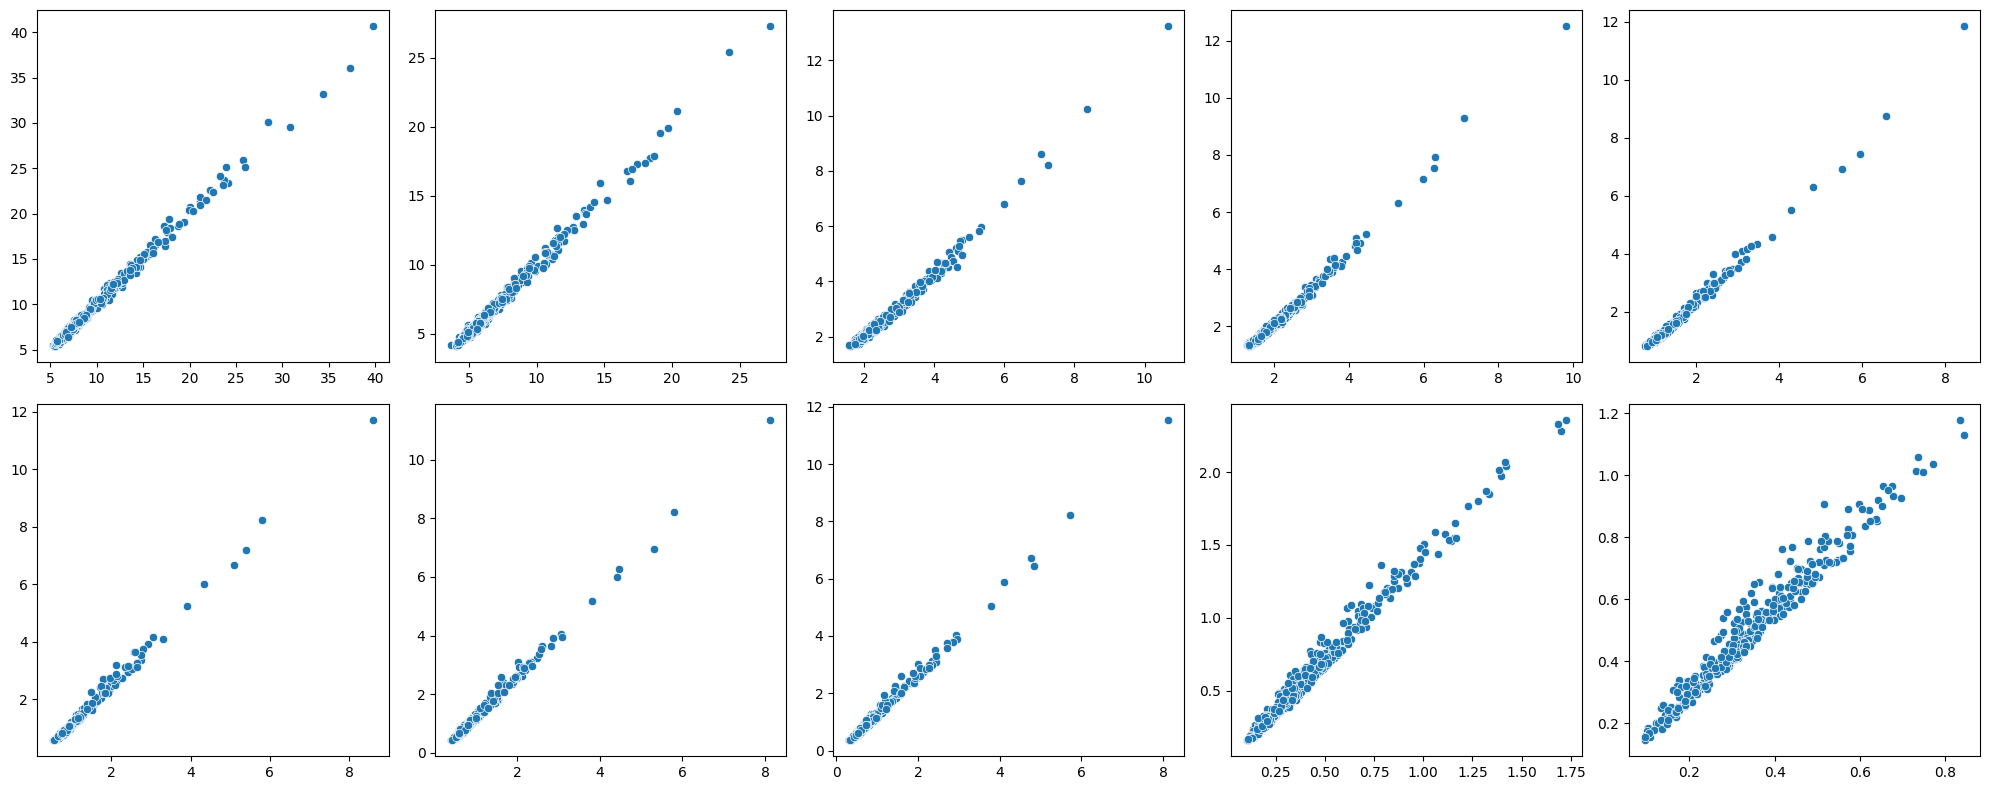

In [ ]:
plt.figure(figsize=(20,8))
plt.subplot(2, 5, 1)
sns.scatterplot(x=means_0_001, y=stds_0_001)
plt.subplot(2, 5, 2)
sns.scatterplot(x=means_0_1, y=stds_0_1)
plt.subplot(2, 5, 3)
sns.scatterplot(x=means_1, y=stds_1)
plt.subplot(2, 5, 4)
sns.scatterplot(x=means_1_5, y=stds_1_5)
plt.subplot(2, 5, 5)
sns.scatterplot(x=means_3, y=stds_3)
plt.subplot(2, 5, 6)
sns.scatterplot(x=means_5, y=stds_5)
plt.subplot(2, 5, 7)
sns.scatterplot(x=means_7_5, y=stds_7_5)
plt.subplot(2, 5, 8)
sns.scatterplot(x=means_10, y=stds_10)
plt.subplot(2, 5, 9)
sns.scatterplot(x=means_100, y=stds_100)
plt.subplot(2, 5, 10)
sns.scatterplot(x=means_200, y=stds_200)

plt.tight_layout()


In [ ]:
def evaluate_gamma(data, gammas, num_bootstrap):
    results = {}
    results[0.001] = (means_0_001, stds_0_001)
    results[0.1] = (means_0_1, stds_0_1)
    results[1] = (means_1, stds_1)
    results[1.5] = (means_1_5, stds_1_5)
    results[5] = (means_5, stds_5)
    results[7.5] = (means_7_5, stds_7_5)
    results[10] = (means_10, stds_10)
    results[100] = (means_100, stds_100)
    results[200] = (means_200, stds_200)
    return results


def plot_results(results):
    for gamma, (avg, spread) in results.items():
        # Find the indices of the top 10 instances with the highest average anomaly values
        top_10_indices = np.argsort(avg)[-10:]

        # Get the corresponding average anomaly values and standard deviations
        top_10_avg = avg[top_10_indices]
        top_10_spread = spread[top_10_indices]

        plt.figure(figsize=(10, 6))
        #print('Top 10 indices: ', top_10_indices, 'Top 10 avg: ', top_10_avg, 'Top 10 spread: ',top_10_spread)
        plt.errorbar(range(len(avg)), avg, yerr=spread, fmt='o', ecolor= 'g', color='r',elinewidth=1, ms=1, label=f'Gamma={gamma}')
        plt.errorbar(top_10_indices, top_10_avg, yerr=top_10_spread, fmt='o', ecolor='b', color='m', elinewidth=1, ms=5, label='Top 10 Anomalies')
        plt.xlabel('Instance Index')
        plt.ylabel('Anomaly Score')
        plt.legend()
        plt.title(f'Anomaly Score vs Instance Index for Gamma={gamma}')
        plt.show()

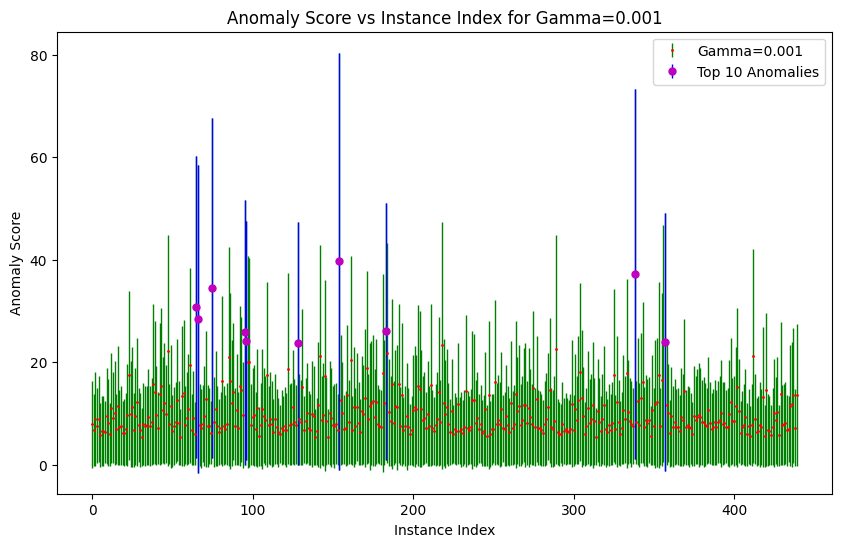

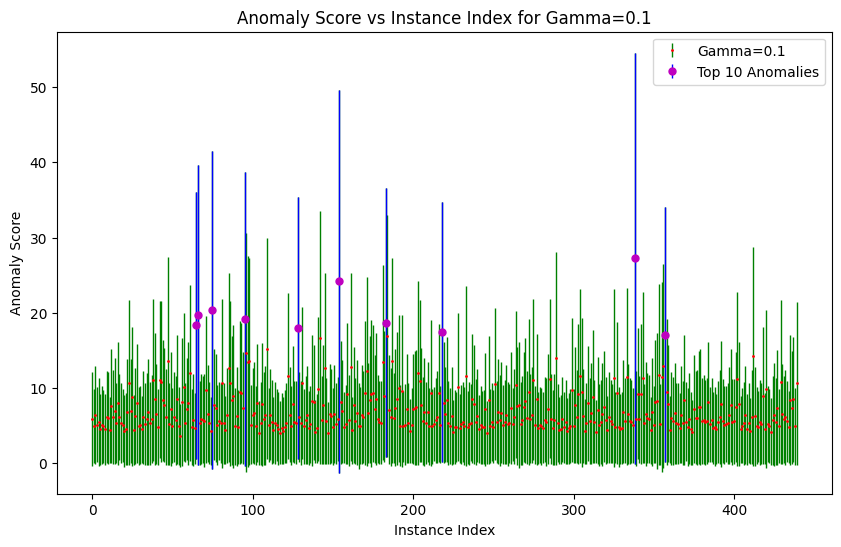

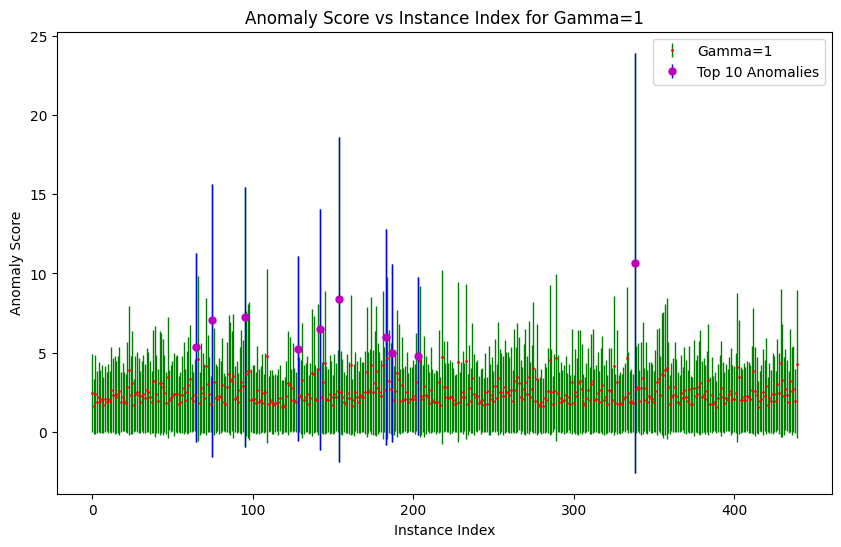

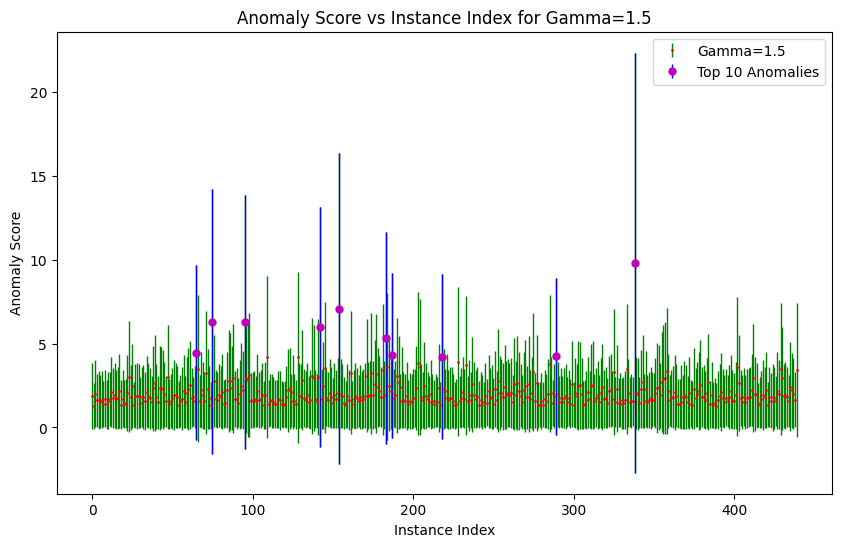

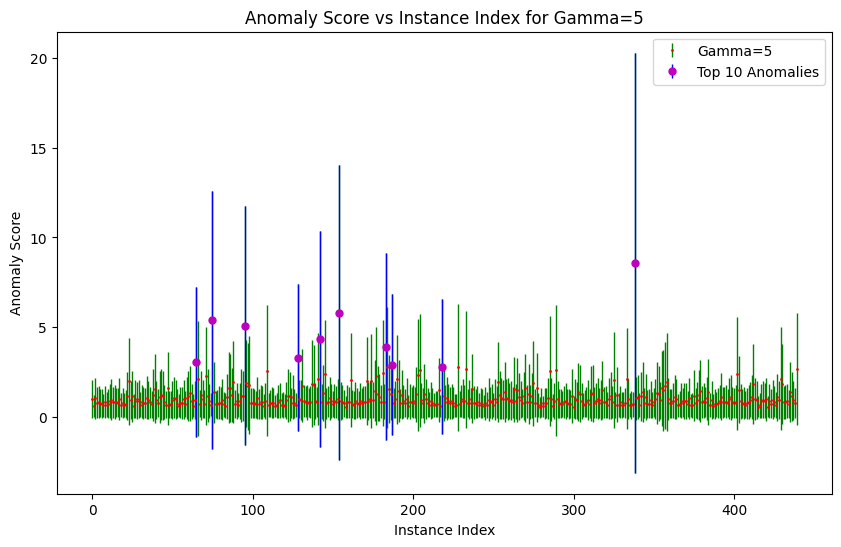

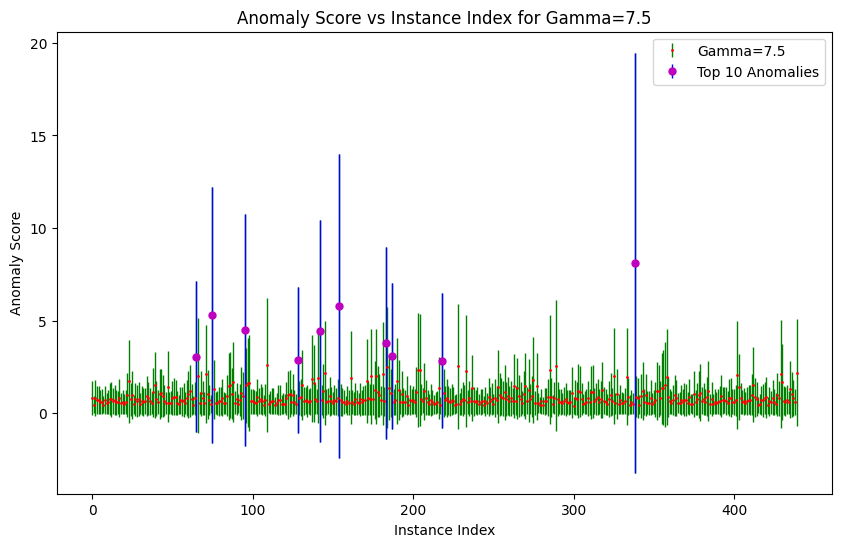

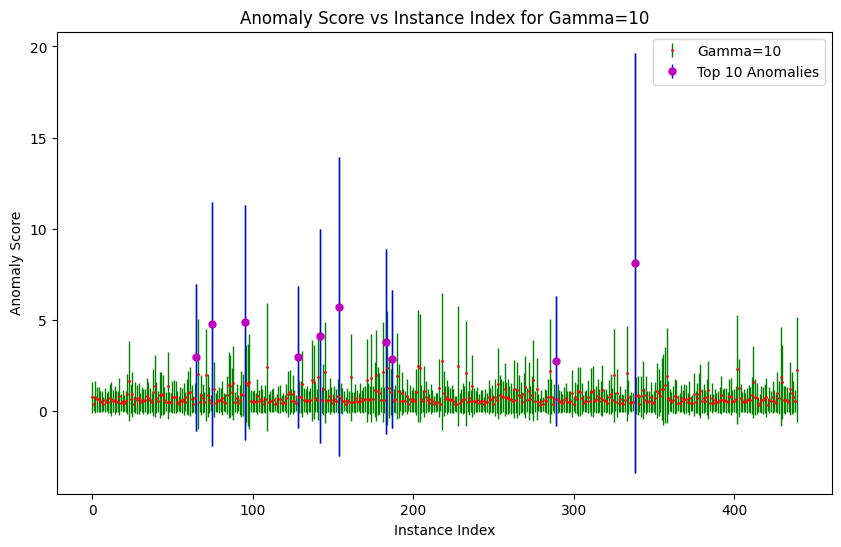

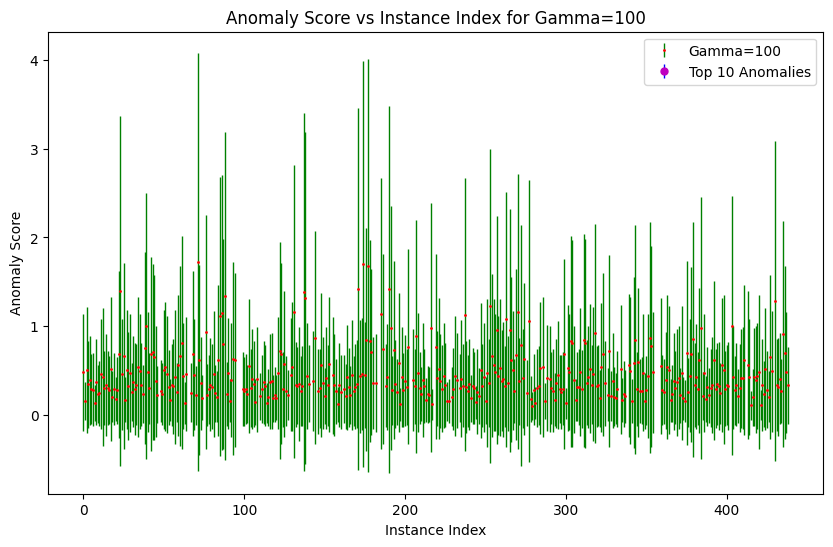

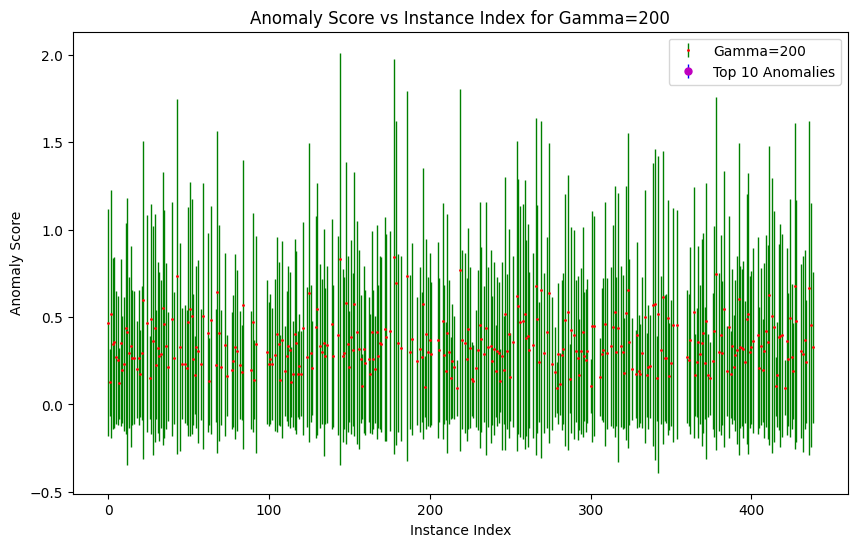

In [ ]:
gammas = [0.001, 0.1, 1, 1.5, 5, 7.5, 10, 100, 200]
results = evaluate_gamma(X_arr,gammas,100)
plot_results(results)

Looks like the separability is the best with gamma == 7.5.

In [ ]:
outlier_scores = outlier_score_softmin(X_arr, 7.5)
outlier_scores = np.array(outlier_scores)

# top 10 if gamma = 7.5
dic = {"score": [], "Fresh": [], "Milk": [], "Grocery": [], "Frozen": [], "Detergents_Paper": [], "Delicassen": []}
indices = []
for idx in np.argsort(outlier_scores)[-10:][::-1]:
    indices.append(idx)
    dic["score"].append(outlier_scores[idx])
    dic["Fresh"].append(X_arr[idx][0])
    dic["Milk"].append(X_arr[idx][1])
    dic["Grocery"].append(X_arr[idx][2])
    dic["Frozen"].append(X_arr[idx][3])
    dic["Detergents_Paper"].append(X_arr[idx][4])
    dic["Delicassen"].append(X_arr[idx][5])
df = pd.DataFrame(dic, index=indices)

In [ ]:
df

,score,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
338,20.012175,2.564949,5.837730,8.858084,9.655731,3.218876,6.327937
75,13.814372,9.923682,7.044905,2.564949,8.393216,2.564949,6.892642
154,13.682043,6.448889,4.174387,4.990433,4.442651,2.833213,2.890372
95,12.140519,2.564949,7.982758,8.742255,6.109248,5.451038,6.577861
183,9.447899,10.514801,10.691035,9.912447,10.506272,5.517453,10.777977
142,9.393954,10.519916,8.876545,9.019543,8.008033,3.401197,2.564949
187,7.366132,7.803027,8.988696,9.193092,8.744966,8.151622,2.564949
128,7.200741,5.010635,9.088963,8.251403,5.023881,6.977281,2.564949
228,6.963405,7.538495,6.375025,6.366470,6.866933,8.470521,5.361292
65,6.758928,4.553877,9.950800,10.732869,3.828641,10.095801,7.267525


# 3. Getting Insights into Anomalies

## 3.1. Relation Between Anomalies and Meta-Data

In [ ]:
# outlier_scores = outlier_score_softmin(X_arr, 50)
# outlier_scores = np.array(outlier_scores)

In [ ]:
outlier_scores = outlier_score_softmin(X_arr, 7.5)
outlier_scores = np.array(outlier_scores)

### 3.1.1. Based on Channel

In [ ]:
data["Channel"].unique()

array([2, 1])

In [ ]:
data["Channel"].value_counts()

Channel
1    298
2    142
Name: count, dtype: int64

<Axes: ylabel='Count'>

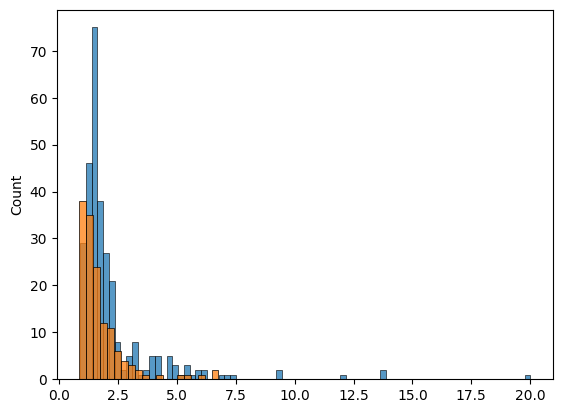

In [ ]:
channel = np.array(data["Channel"])
# tmp = np.vstack((outlier_scores, channel))
indices_1 = [i for i in range(len(channel)) if channel[i] == 1]
indices_2 = [i for i in range(len(channel)) if channel[i] == 2]
sns.histplot(outlier_scores[indices_1])
sns.histplot(outlier_scores[indices_2])

### 3.1.2. Based on Region

In [ ]:
data["Region"].unique()

array([3, 1, 2])

In [ ]:
data["Region"].value_counts()

Region
3    316
1     77
2     47
Name: count, dtype: int64

<Axes: ylabel='Count'>

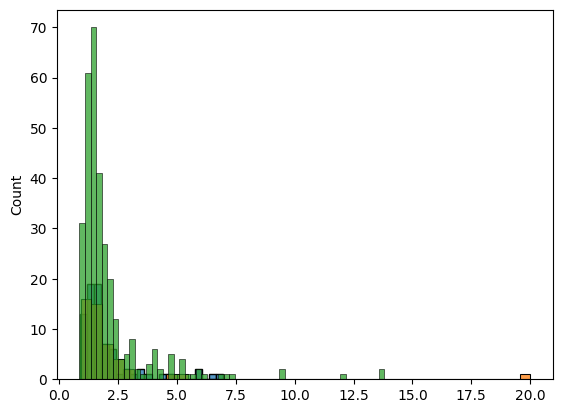

In [ ]:
region = np.array(data["Region"])
indices_1 = [i for i in range(len(region)) if region[i] == 1]
indices_2 = [i for i in range(len(region)) if region[i] == 2]
indices_3 = [i for i in range(len(region)) if region[i] == 3]
sns.histplot(outlier_scores[indices_1])
sns.histplot(outlier_scores[indices_2])
sns.histplot(outlier_scores[indices_3])

## 3.2. Identifying Input Features that Drive Anomaly

In [ ]:
def compute_contribution_to_anomaly_score(data, gamma):
    num_instances = len(data)
    dists = scipy.spatial.distance.cdist(data, data)
    anomaly_scores = outlier_score_softmin(data, gamma)
    contributions = np.zeros((num_instances,num_instances))
    for j in range(num_instances):
        # Exclude the self-distance
        distance_j = np.delete(dists[j], j)
        total_exp_distances = np.sum(np.exp(-gamma * distance_j))
        for i in range(num_instances):
            if i != j:
                exp_distances =np.exp(-gamma *dists[j][i])
                contributions[j][i] = exp_distances / total_exp_distances * anomaly_scores[j]

    return contributions

def propagate_contributions_to_input_features(data, contributions):
    num_instances, num_features = data.shape
    feature_contributions = np.zeros((num_instances, num_features))

    for j in range(num_instances):
        for i in range(num_features):
            feature_sum = 0
            for k in range(num_instances):
                features_distance = data[k]-data[j]
                if k != j and np.linalg.norm(features_distance) !=0:
                    feature_sum += (np.abs(features_distance)[i])**2 / np.linalg.norm(features_distance)**2 * contributions[j][k]
            feature_contributions[j, i] = feature_sum
    return feature_contributions

contributions = compute_contribution_to_anomaly_score(X_arr,7.5)
feature_contributions = propagate_contributions_to_input_features(X_arr, contributions)


In [ ]:
anomaly_scores = outlier_scores
np.argsort(anomaly_scores)[-10:]

array([ 65, 228, 128, 187, 142, 183,  95, 154,  75, 338])

In [ ]:
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import dash_bootstrap_components as dbc
import plotly.express as px
import plotly.graph_objects as go
from sklearn.manifold import TSNE
import pandas as pd
import numpy as np

# Load your data
tsne = TSNE(n_components=2, random_state=42)
data_2d = tsne.fit_transform(X_arr)
df = pd.DataFrame(data_2d, columns=['t_SNE 1', 't_SNE 2'])
df['index'] = df.index
top_10_indices = np.argsort(anomaly_scores)[-10:]
df['colors'] = ['anomalies' if i in top_10_indices else 'non_anomalies' for i in df.index]
color_discrete_map = {'anomalies': 'blue', 'non_anomalies': 'orange'}
# Create the scatter plot with t-SNE results
fig = px.scatter(df, x='t_SNE 1', y='t_SNE 2', hover_data=['index'], color='colors',color_discrete_map=color_discrete_map, labels={'t_SNE 1': 't-SNE 1', 't_SNE 2': 't-SNE 2'}, title='t-SNE Scatter Plot')
fig.update_traces(marker=dict(size=8))

# Define the modal for displaying histograms
modal = html.Div(
    [
        dbc.Modal(
            [
                dbc.ModalHeader("Feature Contributions"),
                dbc.ModalBody(
                    dcc.Graph(id='histogram')
                ),
                dbc.ModalFooter(
                    dbc.Button("Close", id="close-modal", className="ml-auto")
                ),
            ],
            id="modal",
            size="lg",
            centered=True,
        ),
    ]
)

# Define the app layout
app = dash.Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])
app.layout = dbc.Container([
    html.H1("t-SNE Scatter Plot"),
    dcc.Graph(id='scatter-plot', figure=fig),
    modal
])

# Define callback to show modal and update histogram on click
@app.callback(
    [Output("modal", "is_open"), Output('histogram', 'figure')],
    [Input("scatter-plot", "clickData"), Input("close-modal", "n_clicks")],
    [dash.dependencies.State("modal", "is_open")],
)
def toggle_modal(click_data, n_clicks, is_open):
    ctx = dash.callback_context
    if ctx.triggered:
        prop_id = ctx.triggered[0]["prop_id"]
        if prop_id == "scatter-plot.clickData":
            if click_data:
                point_index = click_data["points"][0]["customdata"][0]
                # Retrieve feature contributions (replace this with your data)
                feature_contribution = feature_contributions[point_index]
                # Create histogram
                categories = X.columns
                histogram_fig = go.Figure(go.Bar(x=categories,
                                                  y=feature_contribution,marker_color='green'))
                histogram_fig.update_layout(title=f"Feature Contributions for Index {point_index}")
                return not is_open, histogram_fig
    return is_open, dash.no_update

if __name__ == "__main__":
    app.run_server(debug=True)


<IPython.core.display.Javascript object>

In [ ]:
# Calculation of RK
gamma = 7.5
RK = np.zeros((N, N))
for j in range(N):
    sum1 = 0
    for k in range(N):
        if k != j:
            z = np.linalg.norm(X_arr[j] - X_arr[k]) ** 2
            sum1 += np.exp(-1 * gamma * z)

    for k in range(N):
        if k != j:
            z = np.linalg.norm(X_arr[j] - X_arr[k]) ** 2
            r = np.exp(-1 * gamma * z) / sum1 * outlier_scores[j]
            RK[j][k] = r

# Calculation of RI
RI = np.zeros((N, X_arr.shape[1]))
for j in range(N):
    for i in range(X_arr.shape[1]):
        sum2 = 0
        for k in range(N):
            if k != j:
                tmp = (X_arr[j][i] - X_arr[k][i]) ** 2
                z = np.linalg.norm(X_arr[j] - X_arr[k]) ** 2
                sum2 += tmp / z * RK[j][k]
        RI[j][i] = sum2

In [ ]:
from sklearn.manifold import TSNE
RI_embedded = TSNE(n_components=2, learning_rate="auto", init="random").fit_transform(np.array(RI))

In [ ]:
p1 = sns.scatterplot(x=RI_embedded[:, 0], y=RI_embedded[:, 1] ,palette=sns.color_palette("hls", 10), alpha=0.5)

for line in range(0,N):
        p1.text(RI_embedded[:, 0][line]+0.01, RI_embedded[:, 1][line], range(440)[line], horizontalalignment='left', \
                        size='6', color='black')

<Axes: >

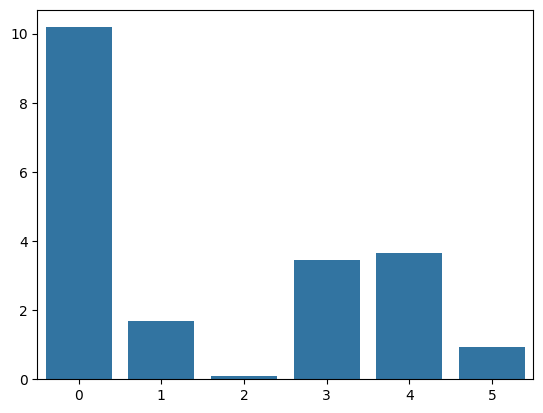

In [ ]:
sns.barplot(x=np.arange(len(RI[338])), y=RI[338])

In [ ]:
sns.barplot(x=np.arange(len(RI[234])), y=RI[234])

In [ ]:
sns.barplot(x=np.arange(len(RI[62])), y=RI[62])

<Axes: >

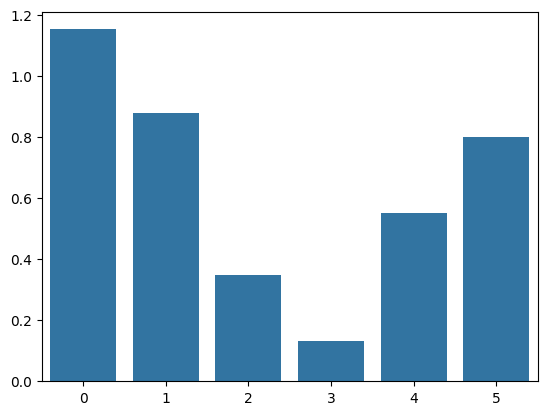

In [ ]:
sns.barplot(x=np.arange(len(RI[412])), y=RI[412])

In [ ]:
print(sum(RI[338]))
print(outlier_scores[338])

20.012174855213665
20.01217485521367
